# Algoritmo MMSE y pseudoblanqueo

In [27]:
import numpy as np

def MMSE(V, L, p_l, h_l, S, Pn):
    """
     ================================INPUTS===================================
    
    V          : señal de radar meteorológico sobremuestrado en rango.

    L          : factor de oversampling.
    
    p_l        : envolvente del pulso transmitido.

    h_l        : respuesta impulsional del receptor.

    S          : potencia de la señal meteorológica.

    Pn         : potencia de ruido.

    ==============================OUTPUTS===============================
    
    X_MMSE     : señal de radar meteorólogico sobremuestreado que reduce el error cuadrático medio.
    C_v        : matriz Toepliz normalizada de correlación.
    """


    # Expresamos las potencias en veces

    S= 10**((S-30)/10)
    Pn= 10**((Pn-30)/10)

    # Algoritmo MMSE 

    ro= np.zeros(L)
    pm= np.convolve(p_l, h_l, "full") # Pm es la convolución de p_l con h_l
    ro= np.convolve(pm,np.conjugate(np.flip(pm)), "full")/(np.sum(pm**2)) # Coeficientes de correlación

    # Encuentro la matriz de correlación C_v^R

    U= np.zeros((L, L), dtype= 'complex_')
    U_conj= np.zeros((L, L), dtype= 'complex_')
    for mm in range(L):     
        U[mm,:]= U[mm,:] + np.roll(ro[-L:], mm)
 
    U= np.triu(U, 0)
    U_h= np.matrix.transpose(U)
    U_h= np.tril( U_h, -1)

    C_v= U + np.conjugate(U_h)  # Matriz de correlación

    # Descomponemos C_v y encontramos la matriz de blanqueo
    
    H= np.linalg.cholesky(C_v) # Descomposición de Cholesky

    # Transformación MMSE

    W_MMSE= np.zeros((L,L), dtype= 'complex_')

    H_t_c= np.conjugate(np.transpose(H)) # H transpuesta y conjugada  
                        
    B= np.dot(H,H_t_c) + (Pn/S)*np.identity(L)            

    W_MMSE= np.dot(H_t_c,np.linalg.inv(B))

    X_MMSE= np.dot(W_MMSE, V) # Datos blanqueados

    # Salida

    return(X_MMSE, C_v)


## Pruebas: 

* Generamos la señal de radar utilizando del simulador.
* Aplicamos el algoritmo MMSE y comparamos las autocorrelaciones.

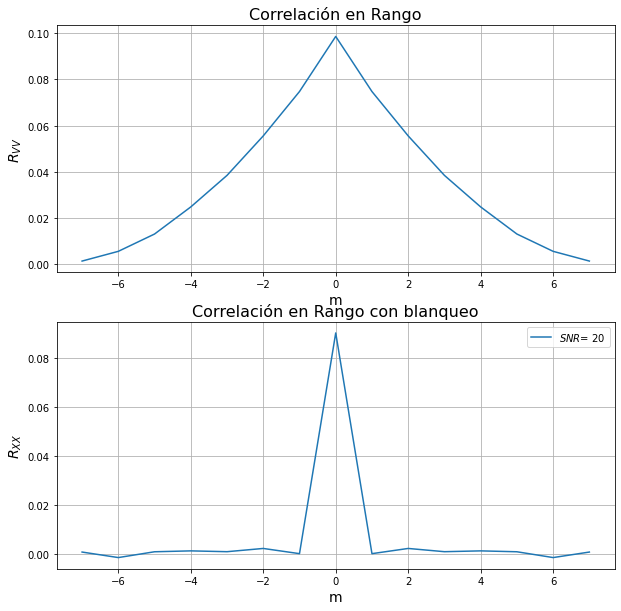

In [28]:
import numpy as np
from datos_sinteticos import datos_sinteticos
from matplotlib import pyplot as plt 

L= 8  # Factor de oversampling
F= 1   # Largo de la respuesta del filtro receptor
M= 256 # Cantidad de pulsos 
h_l= np.ones(F)  # Filtro receptor, una delta en nuestro caso ideal
p_l= np.ones(L) # L muestras del PULSO RECTANGULAR 
S = 20 # Potencia media de la señal de meteorológica, en dBm
sigma_v = 2 # Ancho de banda Doppler, en m/s
v_amax = 32 # Max velocidad ambigüa, en m/s
v_mean = 5 # Velocidad Doppler media, en m/s
Pn = 0  # Potencia de ruido, en dBm
lamb= 0.1 # Frecuencia de operanción, en m 
SNR= S-Pn # SNR en dB
# Datos sintetizados

V= datos_sinteticos(M, L, F, p_l, h_l, S, Pn, v_mean, sigma_v, lamb, v_amax)

# Datos blanqueados

X_MMSE, C_v= MMSE(V, L, p_l, h_l, S, Pn)

# Gráficas 

x= np.arange(-L+1, L)

y= np.zeros(2*L-1, dtype= 'complex_')

y1= np.zeros(2*L-1, dtype= 'complex_')

for i in range(M):
    y += 1/(L*M) * np.correlate(V[:,i], V[:,i], "full") # Correlación en Rango sin traf. de blanqueo
    y1 += 1/(L*M) * np.correlate(X_MMSE[:,i], X_MMSE[:,i], "full") # Correlación en Rango con traf. de blanqueo


# Correlaciones 
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(x, np.real(y))
axs[0].set_xlabel('m', fontdict= {'size': 14})
axs[0].set_ylabel('$R_{VV}$',fontdict= {'size': 14} )
axs[0].set_title('Correlación en Rango', fontdict= {'size': 16})
axs[0].grid(True)

axs[1].plot(x, np.real(y1), label=r'$SNR$= %d' %SNR)
axs[1].set_xlabel('m', fontdict= {'size': 14})
axs[1].set_ylabel('$R_{XX}$', fontdict= {'size': 14})
axs[1].set_title('Correlación en Rango con blanqueo', fontdict= {'size': 16})
axs[1].grid(True)
plt.legend()
plt.show()




# SHARPERING FILTER

In [29]:
import numpy as np

def sharp_filter(V, L, p_l, h_l, alpha):
    """
     ================================INPUTS===================================
    
    V          : señal de radar meteorológico sobremuestrado en rango.

    L          : factor de oversampling.
    
    p_l        : envolvente del pulso transmitido.

    h_l        : respuesta impulsional del receptor.

    alpha      : valor que ajusta el nivel de blanqueo deseado, varía entre 0 (Filtro adaptado) y 1 (Blanqueo puro).


    ==============================OUTPUTS===============================
    
    X_SH       : señal de radar meteorólogico sobremuestreado pseudo-blanqueada.
    C_v        : matriz Toepliz normalizada de correlación.
    """

    # Algoritmo Sharpering Filter 

    ro= np.zeros(L)
    pm= np.convolve(p_l, h_l, "full") # Pm es la convolución de p_l con h_l
    ro= np.convolve(pm,np.conjugate(np.flip(pm)), "full")/(np.sum(pm**2)) # Coeficientes de correlación

    # Encuentro la matriz de correlación C_v^R

    U= np.zeros((L, L), dtype= 'complex_')
    U_conj= np.zeros((L, L), dtype= 'complex_')
    for mm in range(L):     
        U[mm,:]= U[mm,:] + np.roll(ro[-L:], mm)
 
    U= np.triu(U, 0)
    U_h= np.matrix.transpose(U)
    U_h= np.tril( U_h, -1)

    C_v= U + np.conjugate(U_h)  # Matriz de correlación

    # Descomponemos C_v y encontramos la matriz de blanqueo
    
    H= np.linalg.cholesky(C_v) # Descomposición de Cholesky

    # Descomponemos en valores singulares H
    
    Q, S_may, P= np.linalg.svd(H, full_matrices=True)
 
    g=0 

    for i in range(L):
        g+= S_may[i]**4 /((alpha* S_may[i]**2 + (1-alpha))**(2))

    gamma_sh= np.sqrt(L*1/g) 

    W_SH= gamma_sh*np.linalg.inv(alpha*H + (1-alpha)*np.linalg.inv(np.conjugate(np.transpose(H))))

    X_SH= np.dot(W_SH,V)

    # Salida

    return(X_SH, C_v, gamma_sh)


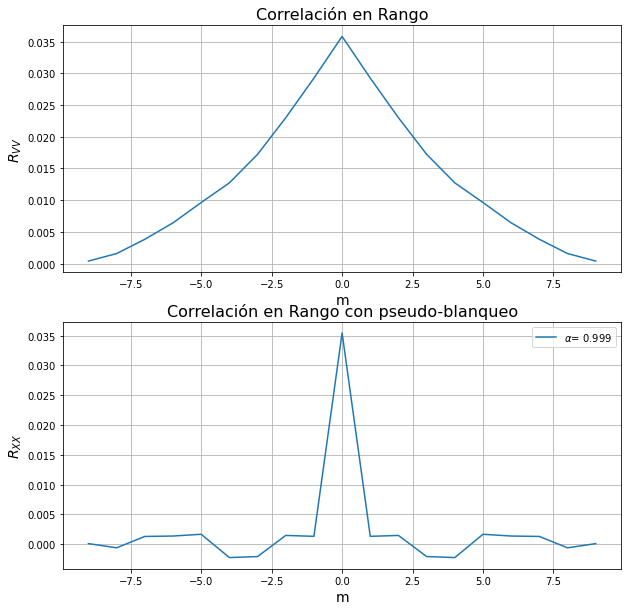

In [30]:
import numpy as np
from datos_sinteticos import datos_sinteticos
from matplotlib import pyplot as plt 

L= 10  # Factor de oversampling
F= 1   # Largo de la respuesta del filtro receptor
M= 256 # Cantidad de pulsos 
h_l= np.ones(F)  # Filtro receptor, una delta en nuestro caso ideal
p_l= np.ones(L) # L muestras del PULSO RECTANGULAR 
S = 15 # Potencia media de la señal de meteorológica, en dBm
sigma_v = 2 # Ancho de banda Doppler, en m/s
v_amax = 32 # Max velocidad ambigüa, en m/s
v_mean = 5 # Velocidad Doppler media, en m/s
Pn = -5  # Potencia de ruido, en dBm
lamb= 0.1 # Frecuencia de operanción, en m 

# Datos sintetizados

V= datos_sinteticos(M, L, F, p_l, h_l, S, Pn, v_mean, sigma_v, lamb, v_amax)

alpha= 0.999 # Valor que va entre 0 y 1 y ajusta el nivel de blanqueo

# Datos pseudo-blanqueados

X_SH, C_v, gamma_sh= sharp_filter(V, L, p_l, h_l, alpha)

# Gráficas 

x= np.arange(-L+1, L)

y= np.zeros(2*L-1, dtype= 'complex_')

y1= np.zeros(2*L-1, dtype= 'complex_')

for i in range(M):
    y += 1/(L*M) * np.correlate(V[:,i], V[:,i], "full") # Correlación en Rango sin traf. de blanqueo
    y1 += 1/(L*M) * np.correlate(X_SH[:,i], X_SH[:,i], "full") # Correlación en Rango con traf. de blanqueo


# Correlaciones 
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(x, np.real(y))
axs[0].set_xlabel('m', fontdict= {'size': 14})
axs[0].set_ylabel('$R_{VV}$',fontdict= {'size': 14} )
axs[0].set_title('Correlación en Rango', fontdict= {'size': 16})
axs[0].grid(True)

axs[1].plot(x, np.real(y1), label=r'$\alpha$= %.3f' %alpha)
axs[1].set_xlabel('m', fontdict= {'size': 14})
axs[1].set_ylabel('$R_{XX}$', fontdict= {'size': 14})
axs[1].set_title('Correlación en Rango con pseudo-blanqueo', fontdict= {'size': 16})
axs[1].grid(True)
plt.legend()

plt.show()